<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can try this notebook on a GPU but you will quickly be switching to a TPU. For this model it's worth it.

## Imports and TPU detection

In [0]:
import os
import json
import numpy as np
from matplotlib import pyplot as plt
os.environ['GCS_READ_CACHE_MAX_SIZE_MB'] = '1' # Hack around Colab/GCS cache bug
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

# little wrinkle: Kears models do not yet work on TPU if eager mode is enabled
# tf.enable_eager_execution()

try: # TPU detection
  tpu = tf.contrib.cluster_resolver.TPUClusterResolver() # Picks up a connected TPU on Google's Colab, ML Engine, Kubernetes and Deep Learning VMs accessed through the 'ctpu up' utility
  #tpu = tf.contrib.cluster_resolver.TPUClusterResolver('MY_TPU_NAME') # If auto-detection does not work, you can pass the name of the TPU explicitly (tip: on a VM created with "ctpu up" the TPU has the same name as the VM)
  USE_TPU = True
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  USE_TPU = False
  print("Running on GPU or CPU")

Tensorflow version 1.13.0-rc0

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Running on TPU  ['10.103.162.18:8470']


In [0]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels, one_hot_labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      numpy_one_hot_labels = one_hot_labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      (numpy_images,
       numpy_labels,
       numpy_one_hot_labels) = ses.run(get_next_item)

  return numpy_images, numpy_labels, numpy_one_hot_labels

def title_from_label_and_one_hot(label, one_hot_label):
  return label.decode("utf-8") + ' ' + str(one_hot_label)
def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(label.decode("utf-8"), str(correct), ', shoud be ' if not correct else '',
                              correct_label.decode("utf-8") if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels, one_hot_labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = title_from_label_and_one_hot(labels[i], one_hot_labels[i])
    subplot = display_one_flower(image, title, subplot)
    if subplot > 339:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.array(CLASSES)[np.argmax(predictions, axis=-1)]
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if subplot > 339:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Colab-only auth for this notebook and the TPU

In [0]:
# Auth on Colab (little wrinkle: without auth, Colab will be extremely slow in accessing data from a GCS bucket, even public).
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user()  # Starts an Auth prompt
  if 'COLAB_TPU_ADDR' in os.environ:  # if using a TPU backend
    with tf.Session('grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])) as sess:    
      with open('/content/adc.json', 'r') as auth_info:
        # Propagate the Colab Auth so that the TPU can access your GCS buckets. This is not necessary for
        # the public bucket used in this sample but it will be once you work with your own non-public data.
        tf.contrib.cloud.configure_gcs(sess, credentials=json.load(auth_info))  # Upload the credentials to TPU

## Configuration

In [0]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192/*.tfrec'
IMAGE_SIZE = [192, 192]

if USE_TPU:
  BATCH_SIZE = 128  # On TPU in Keras, this is the per-core batch size. The global batch size is 8x this.
else:
  BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)

VALIDATION_SPLIT = 0.19
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.gfile.Glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 128, there will be 23 batches per training epoch and 5 batch(es) per validation run.


## Read images and labels from TFRecords

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.FixedLenFeature((), tf.string), # tf.string means byte string
        "label": tf.FixedLenFeature((), tf.string),
        "one_hot_label": tf.FixedLenFeature((), tf.string)
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'])
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    one_hot_label = tf.io.decode_raw(example['one_hot_label'], out_type=tf.uint8) # 'decode' byte string into byte list
    one_hot_label = tf.cast(one_hot_label, tf.float32)  # convert one hot labels to floats
    one_hot_label = tf.reshape(one_hot_label, [5])  # explicit fixed size needed on TPU
    label = example['label']  # byte string
    return image, label, one_hot_label

def load_dataset(filenames):  
  # read from tfrecs
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=32)  # this will read from multiple GCS files in parallel
  dataset = records.map(read_tfrecord, num_parallel_calls=32)
  return dataset

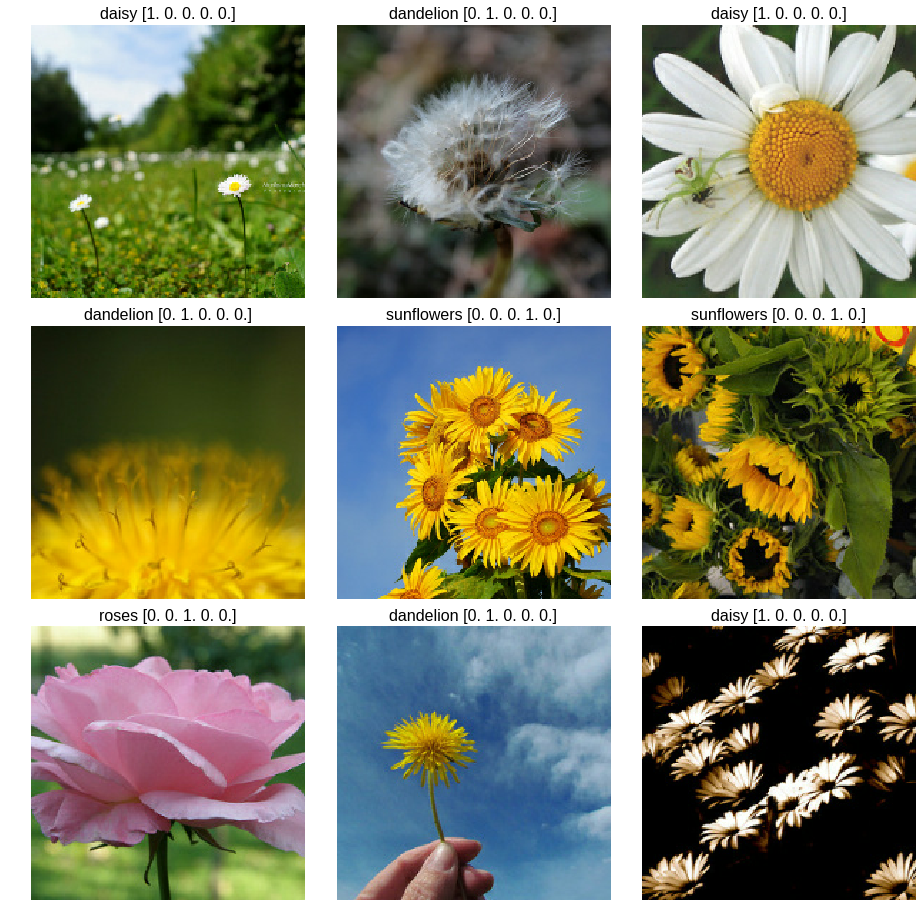

In [0]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [0]:
def features_and_targets(image, label, one_hot_label):
  feature = image
  target = one_hot_label
  return feature, target  # for training, a Keras model needs 2 items: features and targets

def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.map(features_and_targets, num_parallel_calls=32)
  dataset = dataset.cache()  # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder needed on TPU
  dataset = dataset.prefetch(-1) # prefetch next batch while training  (-1: autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset

def get_training_dataset():
  return get_batched_dataset(training_filenames)

def get_validation_dataset():
  return get_batched_dataset(validation_filenames)

some_flowers, some_labels, some_one_hot_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 8*20)

## Model

In [0]:
l = tf.keras.layers

model = tf.keras.Sequential([
    # little wrinkle: specifying the input shape as a Keras InputLayer does not
    # work on TPU yet. Please add an input shape on your first layer instead. 
    #l.InputLayer(input_shape=[*IMAGE_SIZE, 3]),
    
    l.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=[*IMAGE_SIZE, 3]),
    l.Conv2D(kernel_size=3, filters=30, padding='same', activation='relu'),
    l.MaxPooling2D(pool_size=2),
    l.Conv2D(kernel_size=3, filters=60, padding='same', activation='relu'),
    l.MaxPooling2D(pool_size=2),
    l.Conv2D(kernel_size=3, filters=90, padding='same', activation='relu'),
    l.MaxPooling2D(pool_size=2),
    l.Conv2D(kernel_size=3, filters=110, padding='same', activation='relu'),
    l.MaxPooling2D(pool_size=2),
    l.Conv2D(kernel_size=3, filters=130, padding='same', activation='relu'),
    l.Conv2D(kernel_size=1, filters=40, padding='same', activation='relu'),
    l.GlobalAveragePooling2D(),
    l.Dense(5, activation='softmax')
])

model.compile(
  optimizer=tf.train.AdamOptimizer(),
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

model.summary()

# little wrinkle: in eager mode, only tf.train.*Optimizer optimizers will work in model.compile,
# not strings like 'adam' which map to Keras optimizers. Unfortunately the TF optimizers do not
# support Keras learning rate schedules (tf.keras.callbacks.LearningRateScheduler).
# A fix is in the works.

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 30)      4350      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 60)        16260     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 90)        48690     
_________________________________________________________________
max_

## Training

In [0]:
if USE_TPU:
  tpu = tf.contrib.cluster_resolver.TPUClusterResolver()
  strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu)
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

INFO:tensorflow:Querying Tensorflow master (grpc://10.103.162.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15930749728627001626)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12783805603904130806)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5439843757525470038)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2698799054585694677)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 17387279513206319946)
INFO:tensorflow:*** Available Device: _DeviceAttribute

In [0]:
EPOCHS = 15

if USE_TPU:
  history = tpu_model.fit(get_training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                          validation_data=get_validation_dataset, validation_steps=validation_steps)
  # Little wrinkle: reading directly from dataset object not yet implemented
  # for Keras/TPU. Please use a function that returns a dataset.
else:
  history = model.fit(get_training_dataset(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                      validation_data=get_validation_dataset(), validation_steps=validation_steps)

Epoch 1/15
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name=None), TensorSpec(shape=(128, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 5), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_36_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 11.253854274749756 secs
INFO:tensorflow:Setting weights on TPU model.
22/23 [===========================>..] - ETA: 1s - loss: 1.4754 - acc: 0.3542INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name=None), TensorSpec(shape=(128, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 5), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_36_input
INFO:tensorflow:Started compiling
INF

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


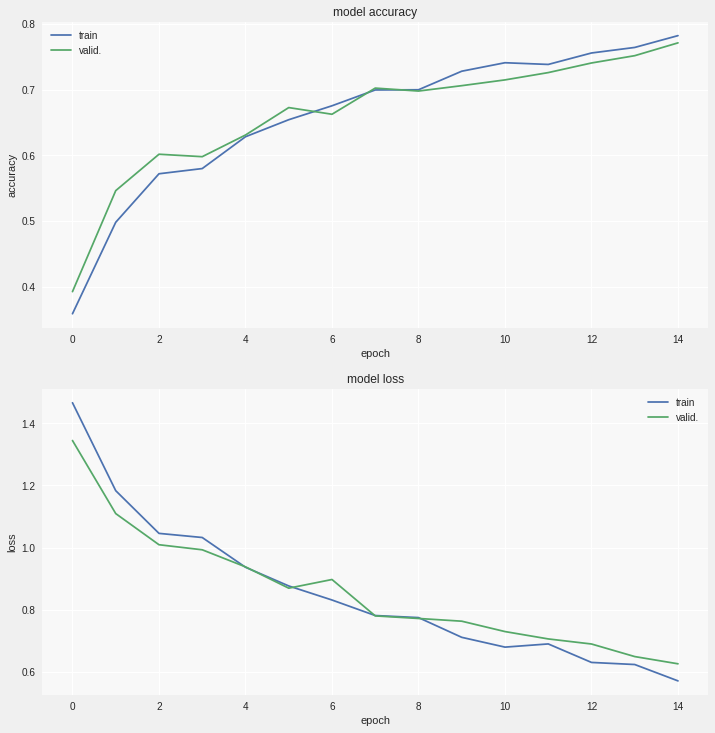

In [0]:
print(history.history.keys())
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [0]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels, some_one_hot_labels = (some_flowers[permutation], some_labels[permutation], some_one_hot_labels[permutation])

if USE_TPU:
  restored_model = model
  restored_model.set_weights(tpu_model.get_weights()) # this copies the weights from TPU to CPU
  predictions = restored_model.predict(some_flowers)
  evaluations = restored_model.evaluate(some_flowers, some_one_hot_labels)
else:
  predictions = model.predict(some_flowers, batch_size=16)
  evaluations = model.evaluate(some_flowers, some_one_hot_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

INFO:tensorflow:Copying TPU weights to the CPU
160/160 [==============================] - 3s 18ms/step
[b'sunflowers', b'dandelion', b'roses', b'roses', b'roses', b'sunflowers', b'dandelion', b'roses', b'dandelion', b'dandelion', b'tulips', b'tulips', b'tulips', b'sunflowers', b'tulips', b'dandelion', b'dandelion', b'dandelion', b'sunflowers', b'dandelion', b'roses', b'sunflowers', b'tulips', b'daisy', b'tulips', b'sunflowers', b'dandelion', b'dandelion', b'dandelion', b'roses', b'sunflowers', b'sunflowers', b'dandelion', b'sunflowers', b'sunflowers', b'sunflowers', b'dandelion', b'roses', b'tulips', b'sunflowers', b'dandelion', b'roses', b'roses', b'roses', b'sunflowers', b'roses', b'dandelion', b'sunflowers', b'daisy', b'roses', b'dandelion', b'roses', b'dandelion', b'dandelion', b'tulips', b'dandelion', b'dandelion', b'dandelion', b'sunflowers', b'tulips', b'roses', b'tulips', b'dandelion', b'roses', b'daisy', b'roses', b'tulips', b'roses', b'dandelion', b'sunflowers', b'dandelion',

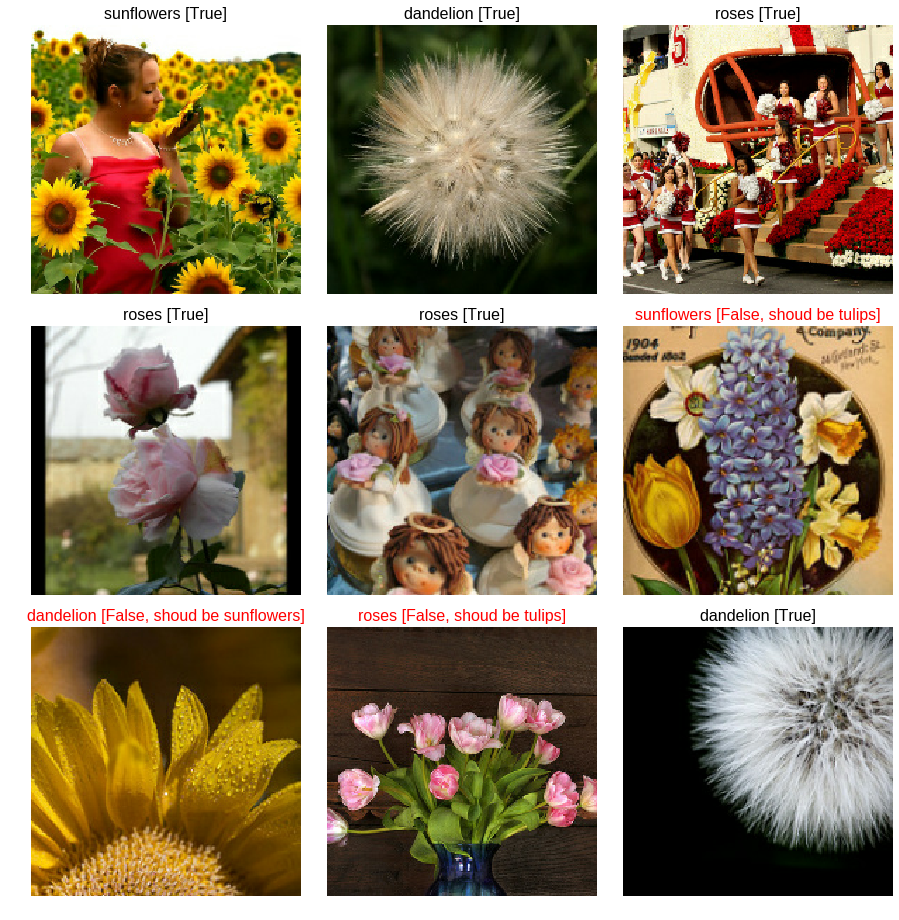

In [0]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
